In [309]:
def parseFiles(startFile, endFile, changingPart):
    files = []
    for runSize in changingPart:
        fileName = startFile + runSize + endFile
        files.append(fileName)
    return files    



In [310]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
from matplotlib import cm
from matplotlib.colors import Normalize

In [311]:
FileExtensions = ["500K", "100K", "50K", "20K", "5M", "1M"]
FileExtensionsMongo = ["500K", "100K", "50K", "20K", "1M"]
FileNameDuring = "output_during_"
FileNameSQLending = "_sql.txt"
FileNameMongoEnding = "_mongo.txt"
files = parseFiles(FileNameDuring, FileNameSQLending, FileExtensions)
filesMongo = parseFiles(FileNameDuring, FileNameMongoEnding, FileExtensionsMongo)

In [312]:
def editFile(fileName):
    with open(fileName, 'r') as file:
        content = file.read()
        
    #1. Put an enter before each occurance of "Sun Dec"
    modifiedContent = content.replace("Sun Dec", "\nSun Dec")
    #2. Put an enter after each occurance of "(Central European Standard Time)"
    modifiedContent = modifiedContent.replace("(Central European Standard Time)", "(Central European Standard Time)\n")
    modifiedContent = modifiedContent.replace(" sampled)", " sampled)\n")
    
    modifiedContent = modifiedContent.replace("\n\n", "\n")
    print(modifiedContent)
    
    with open(fileName, 'w') as file:
        file.write(modifiedContent)
        
    with open(fileName, 'r') as file:
        content = file.readlines()
    
    filtered_lines = [line for line in content if not line.startswith("Sun Dec ")]
    filtered_lines = [line for line in filtered_lines if not line.startswith("Sat Dec ")]
    filtered_lines = [line for line in filtered_lines if not line.startswith("Tue Dec ")]
    filtered_lines = [line for line in filtered_lines if not line.startswith("\n")]
    
    with open(fileName, 'w') as file:
        file.writelines(filtered_lines)

In [313]:
# 1: TODO make dataframe 
def makeDF(files):
    columNames = ["amountData" , "benchmark" , "ops/sec", "error", "runs"]
    dataRest = []
    dataFetchID = []
    dataFetchTime = []
    dataUpdate = []
    dataAddOne = []
    dataAddAll = []
    dataDelete = [] 
    
    for file in files: 
        with open(file, 'r') as file:
            content = file.readlines()
        
        amount = file.name.split("_")[2]
            
        for line in content:
            #print(line)
            # before " x " put in column "benchmark"
            [benchmark, rest] = line.split(" x ")
            # between " x " and " ops/sec" put in column "ops/sec"
            [time, rest] = rest.split(" ops/sec ") 
            time = time.replace(",", "")
            time = float(time)
            #print(time)
            # between "ops/sec " and "(" put in column "error"
            [error, rest] = rest.split(" (")
            # between "(" and "runs sampled" put in column runs 
            [runs, rest] = rest.split(" run")
            runs = int(runs)
            #print(runs)
    
            data = [amount, benchmark, time, error, runs]
            
            # if contains "fetch all last" put in dataFetchTime
            if benchmark.startswith("fetch all last"):
                dataFetchTime.append(data)
            # if contains "fetch all" and "of same id" put in dataFetchID 
            elif benchmark.startswith("fetch all"):
                dataFetchID.append(data)
            # if contains "update" put in dataUpdate 
            elif benchmark.startswith("update"):
                dataUpdate.append(data)
            # if contains "addOne" put in dataAddOne
            elif benchmark.startswith("addOne"):
                dataAddOne.append(data)
            # if contains "addAll" put in dataAddAll
            elif benchmark.startswith("addAll"):
                dataAddAll.append(data)
            # if contains "delete" put in dataDelete
            elif benchmark.startswith("delete"):
                dataDelete.append(data)
            else: dataRest.append(data)
    
    dfFetchId = pd.DataFrame(data=dataFetchID, columns=columNames)
    dfFetchTime = pd.DataFrame(data=dataFetchTime, columns=columNames)
    dfUpdate = pd.DataFrame(data=dataUpdate, columns=columNames)
    dfAddOne = pd.DataFrame(data=dataAddOne, columns=columNames)
    dfAddAll = pd.DataFrame(data=dataAddAll, columns=columNames)
    dfDelete = pd.DataFrame(data=dataDelete, columns=columNames)
    dataRest = pd.DataFrame(data=dataRest, columns=columNames)
    return [dfFetchId, dfFetchTime, dfUpdate, dfAddOne, dfAddAll, dfDelete, dataRest]

In [314]:
#for file in files: editFile(file)
#for file in filesMongo: editFile(file)
[dfFetchID, dfFetchTime, dfUpdate, dfAddOne, dfAddAll, dfDelete, dataRest] = makeDF(files)
[dfFetchIDMongo, dfFetchTimeMongo, dfUpdateMongo, dfAddOneMongo, dfAddAllMongo, dfDeleteMongo, dataRestMongo] = makeDF(filesMongo)

In [315]:
dfFetchIDMongo['database'] = "mongodb"
dfFetchTimeMongo['database'] = "mongodb"
dfUpdateMongo['database'] = "mongodb"
dfAddOneMongo['database'] = "mongodb"
dfAddAllMongo['database'] = "mongodb"
dfDeleteMongo['database'] = "mongodb"
dataRestMongo['database'] = "mongodb"

In [316]:
dfFetchID['database'] = "sql"
dfFetchID = pd.concat([dfFetchID, dfFetchIDMongo], ignore_index=True)
dfFetchID['benchmark'] = dfFetchID['benchmark'].str.replace('^fetch all ', '', regex=True)
dfFetchID['benchmark'] = dfFetchID['benchmark'].str.replace('of same id', 'all', regex=True)
dfFetchID['benchmark'] = dfFetchID['benchmark'].str.replace('lights all', 'lights', regex=True)
dfFetchID['benchmark'] = dfFetchID['benchmark'].str.replace('sensonrs all', 'sensors', regex=True)
dfFetchID['benchmark'] = dfFetchID['benchmark'].str.replace('sensors all', 'sensors', regex=True)
dfFetchID['benchmark'] = dfFetchID['benchmark'].str.replace('pluggs all', 'pluggs', regex=True)
dfFetchID


,amountData,benchmark,ops/sec,error,runs,database
0,500K,lights,7.85,±0.82%,104,sql
1,500K,sensors,7.94,±1.82%,103,sql
2,500K,pluggs,8.29,±0.08%,106,sql
3,500K,all,2.74,±0.08%,56,sql
4,100K,lights,40.72,±0.39%,151,sql
5,100K,sensors,40.83,±0.09%,150,sql
6,100K,pluggs,41.75,±0.10%,153,sql
7,100K,all,13.89,±0.12%,153,sql
8,50K,lights,78.16,±0.81%,168,sql
9,50K,sensors,78.88,±0.73%,169,sql


In [317]:
dfFetchTime['database'] = "sql"
dfFetchTime = pd.concat([dfFetchTime, dfFetchTimeMongo], ignore_index=True)
dfFetchTime['benchmark'] = dfFetchTime['benchmark'].str.replace('^fetch all last ', '', regex=True)
dfFetchTime[['benchmark', 'dataset']] = dfFetchTime['benchmark'].str.split('--', expand=True)
dfFetchTime['benchmark'] = dfFetchTime['benchmark'].str.replace('10 minutes', '10', regex=True)
dfFetchTime['benchmark'] = dfFetchTime['benchmark'].str.replace('15 minutes', '15', regex=True)
dfFetchTime['benchmark'] = dfFetchTime['benchmark'].str.replace('30 minutes', '30', regex=True)
dfFetchTime['benchmark'] = dfFetchTime['benchmark'].str.replace('minute', '1', regex=True)
dfFetchTime['benchmark'] = dfFetchTime['benchmark'].str.replace('12 hours', '720', regex=True)
dfFetchTime['benchmark'] = dfFetchTime['benchmark'].str.replace('2 hours', '120', regex=True)
dfFetchTime['benchmark'] = dfFetchTime['benchmark'].str.replace('5 hours', '300', regex=True)
dfFetchTime['benchmark'] = dfFetchTime['benchmark'].str.replace('24 hours', '1440', regex=True)
dfFetchTime['benchmark'] = dfFetchTime['benchmark'].str.replace('hour', '60', regex=True)
dfFetchTime['benchmark'] = dfFetchTime['benchmark'].astype(int)
dfFetchTime['dataset'] = dfFetchTime['dataset'].str.replace('(20000 records)', '', regex=True)

dfFetchTime
#dfFetchTimeMongo

,amountData,benchmark,ops/sec,error,runs,database,dataset
0,500K,1,3.51,±0.21%,63,sql,lamp ()
1,500K,1,3.56,±0.07%,64,sql,sensor ()
2,500K,1,3.60,±0.05%,64,sql,pluggs ()
3,500K,10,3.52,±0.05%,64,sql,lamp ()
4,500K,10,3.56,±0.08%,64,sql,sensor ()
...,...,...,...,...,...,...,...
270,1M,60,0.86,±0.23%,38,mongodb,all ()
271,1M,120,0.86,±0.21%,38,mongodb,all ()
272,1M,300,0.86,±0.20%,38,mongodb,all ()
273,1M,720,0.85,±0.10%,38,mongodb,all ()


In [318]:
dfUpdate['database'] = "sql"
dfUpdate = pd.concat([dfUpdate, dfUpdateMongo], ignore_index=True)

dfUpdate[['benchmark', 'dataset']] = dfUpdate['benchmark'].str.split(' - ', expand=True)
dfUpdate['dataset'] = dfUpdate['dataset'].str.replace('(20000 records)', '', regex=True)
dfUpdate['benchmark'] = dfUpdate['benchmark'].str.replace('value in a ', '', regex=True)
dfUpdate['benchmark'] = dfUpdate['benchmark'].str.replace('values in a ', '', regex=True)
dfUpdate['benchmark'] = dfUpdate['benchmark'].str.replace('^update ', '', regex=True)
dfUpdate[['benchmark', 'type']] = dfUpdate['benchmark'].str.split(' ', expand=True)
dfUpdate['benchmark'] = dfUpdate['benchmark'].astype(int)

dfUpdate

,amountData,benchmark,ops/sec,error,runs,database,dataset,type
0,500K,1,2766.0,±1.18%,101,sql,lampen (),row
1,500K,2,2676.0,±1.27%,104,sql,lampen (),row
2,500K,3,2899.0,±1.97%,101,sql,lampen (),row
3,500K,1,2699.0,±1.52%,104,sql,lampen (),column
4,500K,2,1377.0,±1.47%,101,sql,lampen (),column
...,...,...,...,...,...,...,...,...
83,1M,1,4931.0,±1.37%,100,mongodb,lampen (),column
84,1M,2,2449.0,±1.40%,100,mongodb,lampen (),columns
85,1M,5,986.0,±1.30%,96,mongodb,lampen (),columns
86,1M,10,488.0,±1.57%,104,mongodb,lampen (),columns


In [319]:
dfAddOne['database'] = "sql"
dfAddOne = pd.concat([dfAddOne, dfAddOneMongo], ignore_index=True)

dfAddOne['benchmark'] = dfAddOne['benchmark'].str.replace('^addOne write ', '', regex=True)
dfAddOne['benchmark'] = dfAddOne['benchmark'].str.replace('1K', '1000', regex=True)
dfAddOne['benchmark'] = dfAddOne['benchmark'].str.replace('5K', '5000', regex=True)
# Replace '()' and its contents using regex
dfAddOne['benchmark'] = dfAddOne['benchmark'].str.replace(r'\(.*?\)', '', regex=True).str.strip()

dfAddOne['benchmark'] = dfAddOne['benchmark'].str.replace('(20000 records)', '', regex=True)
dfAddOne['benchmark'] = dfAddOne['benchmark'].astype(int)

dfAddOne

,amountData,benchmark,ops/sec,error,runs,database
0,500K,1,5799.00,±1.55%,10,sql
1,500K,10,599.00,±0.69%,10,sql
2,500K,100,58.73,±1.76%,10,sql
3,500K,1000,5.99,±0.95%,10,sql
4,500K,5000,1.20,±0.64%,10,sql
5,100K,1,6029.00,±3.60%,10,sql
6,100K,10,588.00,±20.22%,10,sql
7,100K,100,60.81,±3.32%,10,sql
8,100K,1000,5.96,±1.05%,10,sql
9,100K,5000,1.21,±0.35%,10,sql


In [320]:
dfAddAll['database'] = "sql"
dfAddAll = pd.concat([dfAddAll, dfAddAllMongo], ignore_index=True)

dfAddAll['benchmark'] = dfAddAll['benchmark'].str.replace('^addAll write ', '', regex=True)
dfAddAll['benchmark'] = dfAddAll['benchmark'].str.replace(r'\(.*?\)', '', regex=True).str.strip()
dfAddAll['benchmark'] = dfAddAll['benchmark'].astype(int)
dfAddAll

,amountData,benchmark,ops/sec,error,runs,database
0,500K,1,94864.0,±0.00%,1,sql
1,500K,10,32933.0,±0.00%,1,sql
2,500K,100,4405.0,±0.00%,1,sql
3,500K,1000,497.0,±0.00%,1,sql
4,100K,1,94650.0,±0.00%,1,sql
5,100K,10,37402.0,±0.00%,1,sql
6,100K,100,4546.0,±0.00%,1,sql
7,100K,1000,598.0,±0.00%,1,sql
8,50K,1,102463.0,±0.00%,1,sql
9,50K,10,33542.0,±0.00%,1,sql


In [321]:
dfDelete['database'] = "sql"
dfDelete = pd.concat([dfDelete, dfDeleteMongo], ignore_index=True)

dfDelete['benchmark'] = dfDelete['benchmark'].str.replace('^delete ', '', regex=True)
dfDelete['benchmark'] = dfDelete['benchmark'].str.replace(' record lampen', '', regex=True)
dfDelete['benchmark'] = dfDelete['benchmark'].str.replace('1K', '1000', regex=True)
dfDelete['amountData'] = dfDelete['amountData'].str.replace('500K', '500000', regex=True)
dfDelete['amountData'] = dfDelete['amountData'].str.replace('100K', '100000', regex=True)
dfDelete['amountData'] = dfDelete['amountData'].str.replace('50K', '50000', regex=True)
dfDelete['amountData'] = dfDelete['amountData'].str.replace('10K', '10000', regex=True)
dfDelete['amountData'] = dfDelete['amountData'].str.replace('20K', '20000', regex=True)
dfDelete['amountData'] = dfDelete['amountData'].str.replace('5M', '5000000', regex=True)
dfDelete['amountData'] = dfDelete['amountData'].str.replace('1M', '1000000', regex=True)
dfDelete['amountData'] = dfDelete['amountData'].astype(int)
dfDelete

,amountData,benchmark,ops/sec,error,runs,database
0,500000,1,131.00,±0.13%,109,sql
1,500000,10,13.08,±0.14%,88,sql
2,500000,100,1.30,±0.16%,36,sql
3,500000,1000,0.13,±0.09%,30,sql
4,100000,1,135.00,±0.13%,111,sql
5,100000,10,13.47,±0.15%,89,sql
6,100000,100,1.34,±0.14%,36,sql
7,100000,1000,0.13,±0.15%,30,sql
8,50000,1,137.00,±0.24%,106,sql
9,50000,10,13.78,±0.23%,90,sql


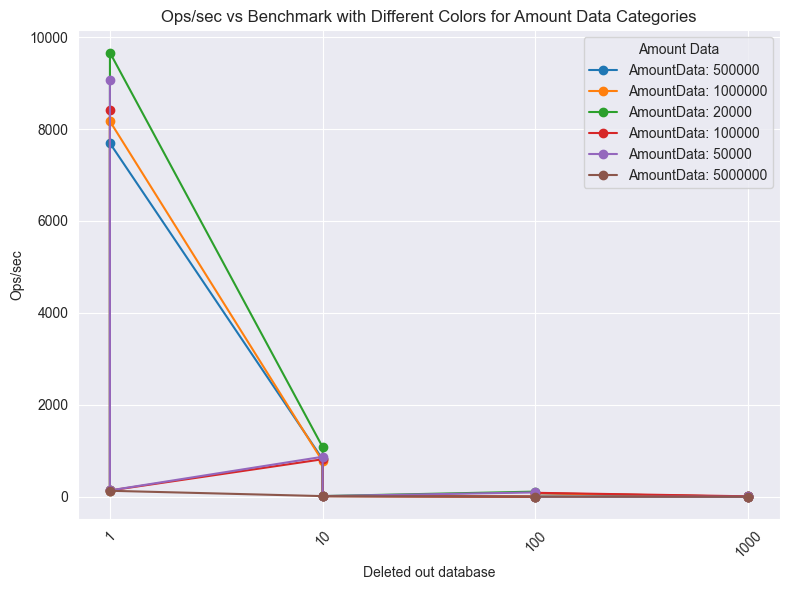

In [322]:
dfDelete = dfDelete.sort_values(by='benchmark')

# Create a plot figure
fig, ax = plt.subplots(figsize=(8, 6))

# Define a set of colors for each 'amountData' category
colors = {10: 'blue', 1000000: 'green', 500000: 'red'}  # Customize as needed


# Loop through each unique 'amountData' value and plot the corresponding line
for amount in dfDelete['amountData'].unique():
    # Filter data for the current amountData value
    subset = dfDelete[dfDelete['amountData'] == amount]
    
    # Plot the data with a specific color for each amountData
    ax.plot(subset['benchmark'], subset['ops/sec'], marker='o', label=f'AmountData: {amount}')

# Add titles and labels
ax.set_title('Ops/sec vs Benchmark with Different Colors for Amount Data Categories')
ax.set_xlabel('Deleted out database')
ax.set_ylabel('Ops/sec')

# Add a legend
ax.legend(title='Amount Data')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


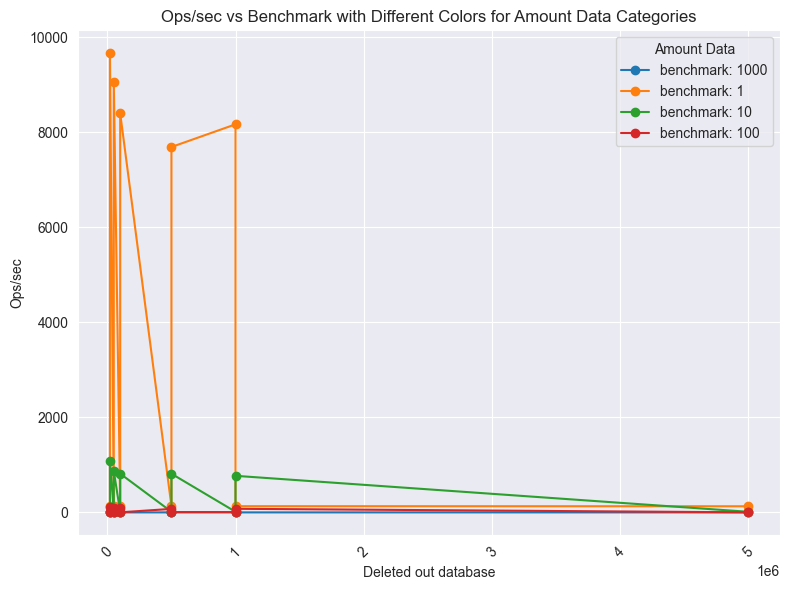

In [323]:
dfDelete = dfDelete.sort_values(by='amountData')

# Create a plot figure
fig, ax = plt.subplots(figsize=(8, 6))

# Define a set of colors for each 'amountData' category
colors = {10: 'blue', 1000000: 'green', 500000: 'red'}  # Customize as needed


# Loop through each unique 'amountData' value and plot the corresponding line
for amount in dfDelete['benchmark'].unique():
    # Filter data for the current amountData value
    subset = dfDelete[dfDelete['benchmark'] == amount]
    
    # Plot the data with a specific color for each amountData
    ax.plot(subset['amountData'], subset['ops/sec'], marker='o', label=f'benchmark: {amount}')

# Add titles and labels
ax.set_title('Ops/sec vs Benchmark with Different Colors for Amount Data Categories')
ax.set_xlabel('Deleted out database')
ax.set_ylabel('Ops/sec')

# Add a legend
ax.legend(title='Amount Data')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


KeyError: 20000

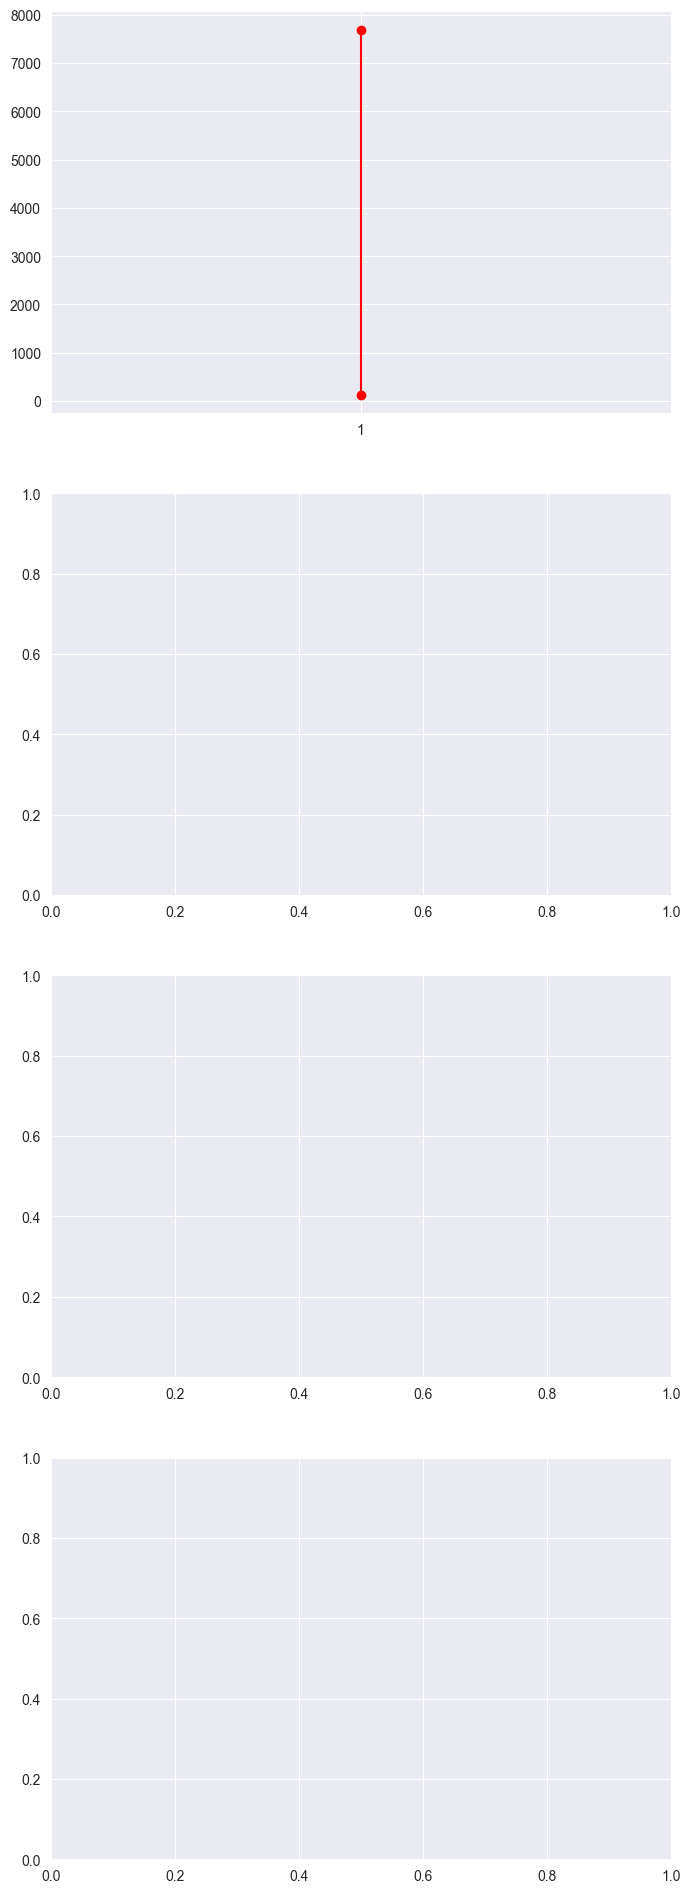

In [324]:
# Sort the DataFrame by the 'benchmark' column (or another column if needed)
dfDelete = dfDelete.sort_values(by='benchmark')

# Get unique 'benchmark' values to create separate plots
benchmarks = dfDelete['benchmark'].unique()

# Number of subplots required
num_benchmarks = len(benchmarks)

# Create subplots (one for each 'benchmark')
fig, axes = plt.subplots(num_benchmarks, 1, figsize=(8, 6 * num_benchmarks))

# If there's only one benchmark, `axes` will not be an array, so we need to handle that case
if num_benchmarks == 1:
    axes = [axes]

# Loop through each benchmark and create a subplot
for i, benchmark in enumerate(benchmarks):
    # Filter data for the current benchmark
    subset = dfDelete[dfDelete['benchmark'] == benchmark]

    # Plot the data with a specific color for each 'amountData' category
    for amount in subset['amountData'].unique():
        # Filter the subset for the current 'amountData'
        subset_amount = subset[subset['amountData'] == amount]
        
        # Plot the data
        axes[i].plot(subset_amount['benchmark'], subset_amount['ops/sec'], marker='o', label=f'AmountData: {amount}', color=colors[amount])

    # Add titles and labels
    axes[i].set_title(f'Ops/sec vs AmountData for {benchmark}')
    axes[i].set_xlabel('Benchmark')
    axes[i].set_ylabel('Ops/sec')

    # Add a legend for each subplot
    axes[i].legend(title='Amount Data')

# Adjust layout
plt.tight_layout()
plt.show()